# Performance when Dimension of X is Large

In [ ]:
import numpy as np
import statsmodels.api as sm
from scipy.spatial import distance_matrix, distance
import matplotlib.pyplot as plt
import time
from scipy.linalg import orth
import xgboost as xgb
from scipy.optimize import leastsq,minimize
import seaborn as sns

try:
  from linearmodels.iv import IV2SLS
except ImportError:
  !pip install linearmodels
  from linearmodels.iv import IV2SLS

np.random.seed(10000)

# Draw some means for each feature
means = np.random.uniform(-10,10,4)

V = 200
p = 50 ###
covariate_obs = np.column_stack((np.random.normal(means[0],1,V),
                         np.random.normal(means[1],1,V),
                         np.random.normal(means[2],1,V)))

covariate_unobs = np.random.normal(means[3],1,V)
graph_info = np.column_stack((covariate_obs[:,1:3],covariate_unobs))
dist_mat = distance_matrix(graph_info,graph_info)

A = (dist_mat<0.4).astype(int)

# Set the main diagonal to 0's
np.fill_diagonal(A,0)

T = np.random.choice([0,1],V,p=[0.5,0.5])
eps = np.random.normal(0,0.1,V)

# l-2 distance matrix (assumed known)
location = np.random.normal(0,3,V).reshape(V,1)
D = distance_matrix(location,location) # graph weights

# Weighted adjacency matrix
A_weighted = np.multiply(A,D)
B_weighted = np.diag(np.sum(A_weighted,1)**(0.5))
for i in range(V):
    if B_weighted[i,i] ==0:
        next
    else:
        B_weighted[i,i] = 1/B_weighted[i,i]

# Normalized A_weighted
G_weighted = B_weighted@A_weighted@B_weighted

beta0 = 0.4666
treated = np.where(T==1)[0]
control = np.where(T==0)[0]
sigma = 20 # Kernel bandwidth
lam = 0.001 # kernel regularization term

beta_hat = 0.2 # must be in (-1,1)
parameters = [beta_hat]

# Generate p covariates
X = np.zeros((V, p))
for i in range(p):
    if i % 2 == 0:
        X[:, i] = np.random.normal(0, 1, V)  # Normal distribution
    elif i % 3 == 0:
        X[:, i] = np.random.uniform(-1, 1, V)  # Uniform distribution
    elif i % 5 == 0:
        X[:, i] = np.random.exponential(1, V)  # Exponential distribution
    else:
        X[:,i] = np.random.binomial(1, 0.5, V) #binomial distribution

# Create a non-linear function to map each observation of X to a real number.
def non_linear_function(x):
    # Example non-linear function (modify as needed)
    return np.sin(x[0]) + x[1]**2 + np.exp(x[2]) + np.sum(x[3:])

# Apply the function to each observation and store the results in fx.
fx = np.apply_along_axis(non_linear_function, 1, X)
fxZ = np.multiply(fx,T)

### Generate outcomes using reduced-form ###
IbG = np.linalg.matrix_power((np.diag(np.ones(V))-beta0*A_weighted),-1) #$$$$$$$$$$$$$$$ A<=>G_weighted
Y = IbG@(fxZ+eps)



### Estimation ###
iteration = 1
K = np.exp(-distance_matrix(X[treated].reshape(int(sum(T)),p),X[treated].reshape(int(sum(T)),p))**2/(2*sigma**2))
rsq = 1

while True:
    Y_tilde = Y-beta_hat*A_weighted@Y
    C_hat = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde[treated]
    KC = K@C_hat

    rsq_new = 1-np.dot(fxZ[treated]-KC,fxZ[treated]-KC)/np.dot(fxZ[treated]-np.mean(fxZ[treated]),fxZ[treated]-np.mean(fxZ[treated]))

    fx_hat = np.zeros(V)
    fx_hat[treated] = KC

    q = 5
    iv1 = np.array([np.linalg.matrix_power(A_weighted,(k+2))@np.multiply(fx_hat,T) for k in range(q)]).T

    ivreg = IV2SLS(
        dependent = Y-fx_hat, # dependent variable
        exog = None, # exogenous regressors
        endog = A_weighted@Y, # endogenous regressors
        instruments = iv1, # instrumental variables
        weights = None).fit(cov_type="unadjusted")

    beta_hat = ivreg.params.iloc[0]
    parameters = np.column_stack((parameters,ivreg.params))
    iteration += 1

    if abs(rsq_new-rsq)<0.00000001:
        print('R-squared:',round(rsq_new,4))
        print("Estimation converged")
        break
    rsq = rsq_new

R-squared: 0.9966
Estimation converged


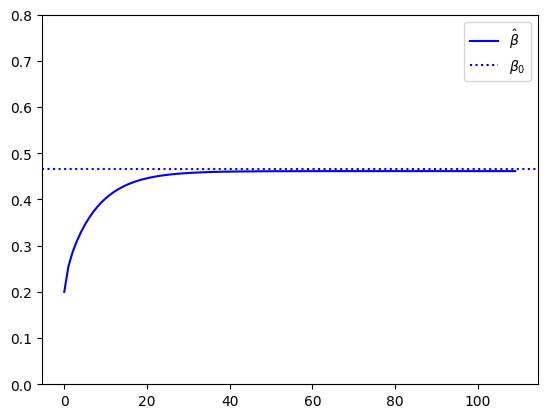

In [ ]:
plt.plot(range(iteration),parameters[0,:],color='b',label=r'$\hat\beta$')
plt.axhline(beta0, color='b',linestyle=':',label=r'$\beta_0$')
plt.ylim(0,0.8)
plt.legend(loc=1)

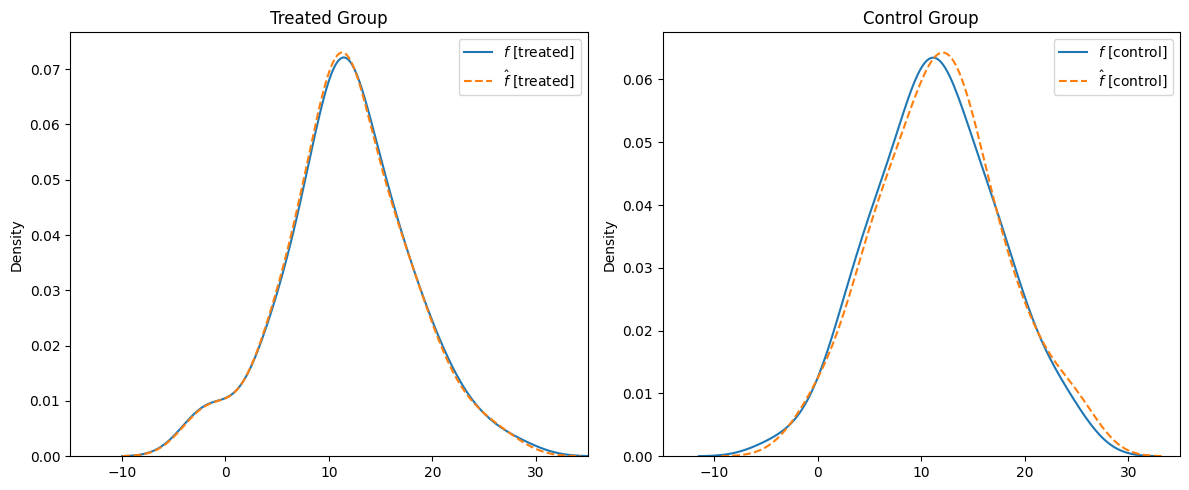

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.kdeplot(fx[treated], ax=axes[0], label=r'$f$ [treated]')
sns.kdeplot(fx_hat[treated], ax=axes[0], linestyle='--', label=r'$\hat{f}$ [treated]')
axes[0].set_xlim(-15,35)
axes[0].set_title('Treated Group')
axes[0].legend()

# Plot 2
d1 = distance_matrix(X[control], X[treated])
fx_hat[control] = np.exp(-d1**2/(2*sigma**2))@C_hat
sns.kdeplot(fx[control], ax=axes[1], label=r'$f$ [control]')
sns.kdeplot(fx_hat[control], ax=axes[1], linestyle='--', label=r'$\hat{f}$ [control]')
axes[1].set_xlim(-15, 35)
axes[1].set_title('Control Group')
axes[1].legend()

plt.tight_layout()
plt.show()